In [234]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Identification of influential users in social network using gray wolf optimization algorithm

### Ahmad Zareiec, Amir Sheikhahmadia, Mahdi Jalilib

https://www.sciencedirect.com/science/article/pii/S095741741930689X?via%3Dihub

## Hamsterster Dataset

Link: https://relational.fit.cvut.cz/dataset/CORA

This Network contains friendships and familylinks between users of the website hamsterster.com.

 -  Format Undirected: Undirected
 -  Edge weights	   Unweighted
 -          Size	   2,426 vertices (users)
 -        Volume   	   16,631 edges (friendships) 

In [14]:
edgelist = pd.read_csv("./dataset/hamster-full/out.petster-hamster", sep=" ")
edgelist.drop(['unweighted'], axis=1, inplace=True)
edgelist.rename(columns={'%': 'Source', 'sym': 'Target'}, inplace=True)
edgelist.head()

,Source,Target
0,99,98
1,999,550
2,999,549
3,999,42
4,999,25


In [15]:
edgelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16631 entries, 0 to 16630
Data columns (total 2 columns):
Source    16631 non-null int64
Target    16631 non-null int64
dtypes: int64(2)
memory usage: 260.0 KB


In [16]:
p = 0.03 # Activation Probability used in independent cascade model
k = 5    # Seed Size
max_t = 1000  # Max Iterations

In [17]:
hamsterster = nx.read_edgelist("./dataset/hamster-full/out.petster-hamster", comments = '%')

In [18]:
num_nodes = hamsterster.number_of_nodes()
num_edges = hamsterster.number_of_edges()
num_nodes, num_edges

(2426, 16631)

In [19]:
def neighbors(idx):
    return list(dict(hamsterster.adjacency())[str(int(idx))])

def len_second_neighbors(idx, neighbor_list=None):
    if neighbor_list is None:
        neighbor_list = neighbors(idx)
    l = []
    for t in neighbor_list:
        l += neighbors(t)
    if str(idx) in l:
        return len(l) - 1
    else:
        return len(l)

## Fitness

In [213]:
# Equation 13
def get_seed_set(vec, sol_size):
    try:
        return np.argsort(vec[0, :])[- sol_size - 1:-1] + 1
    except IndexError:
        return np.argsort(vec)[-sol_size-1:-1] + 1

def fitness(position_vec, sol_size):
    wcj = []
    if position_vec.shape[0] != 1:
        position_vec = np.reshape(position_vec, newshape=(1, -1))
    seed_set = get_seed_set(position_vec, sol_size)
    for seed in seed_set:
        nb_list = neighbors(seed)
        dj = len(nb_list)
        Ivj = p * dj * (dj + len_second_neighbors(seed, nb_list) * p)
        wcj.append(Ivj)

    return -1* np.sum(wcj * np.log(wcj/np.sum(wcj))) / np.sum(wcj) # Entropy

## Wolves

In [217]:
# Algorithm 3
def init_wolf(graph):
    X = np.random.random((1, len(graph))) * list(dict(graph.degree()).values())
#     X /= np.sum(X, axis=1)[:, None]
    return X

def init_omega_wolves(num, graph):
    X = np.random.random((num, len(graph))) * list(dict(graph.degree()).values())
#     X /= np.sum(X, axis=1)[:, None]
    return X

In [239]:
# Equation 7, 8, 9
def update_random_constant_vectors(r1, r2, t):    
    a = 2. - 2. * t / max_t
    A = 2 * r1 * a - a
    C = 2 * r2
    return a, A, C

In [219]:
# Algorithm 4
def update_omega_wolf(A, C, V, Xi, alpha, beta, delta):
    Y1 = alpha - A[0, :] * np.abs(C[0, :] * alpha - Xi)
    Y2 = alpha - A[1, :] * np.abs(C[1, :] * delta - Xi)
    Y3 = alpha - A[2, :] * np.abs(C[2, :] * alpha - Xi)
    Xnew = (Y1 + Y2 + Y3)/3
    return Xnew
    
def update_position_vector(A, C, V, alpha, beta, delta, omega_wolves):
    for i in range(omega_wolves.shape[0]):
        omega_wolves[i, :] = update_omega_wolf(A, C, V, omega_wolves[i, :], alpha, beta, delta)
    return omega_wolves

In [229]:
def init_primary_pack(V, sol_size):
    alpha = init_wolf(V)
    beta = init_wolf(V)
    delta = init_wolf(V)
    
    alpha_score = fitness(alpha, sol_size)
    beta_score = fitness(beta, sol_size)
    delta_score = fitness(delta, sol_size)
    if delta_score > alpha_score:
        delta, alpha = alpha, delta
    if delta_score > beta_score:
        delta, beta = beta, delta
    if beta_score > alpha_score:
        beta, alpha = alpha, beta
    return alpha, beta, delta

def update_pack(alpha, beta, delta, omega_wolves, sol_size):
    alpha_score = fitness(alpha, sol_size)
    beta_score = fitness(beta, sol_size)
    delta_score = fitness(delta, sol_size)
    for i in range(omega_wolves.shape[0]):
        omega_score = fitness(omega_wolves[i:i+1], sol_size)
        if omega_score > alpha_score:
            temp = delta
            delta = beta
            beta = alpha
            alpha = omega_wolves[i, :]
            omega_wolves[i, :] = temp
            del temp
        elif omega_score > beta_score:
            temp = delta
            delta = beta
            beta = omega_wolves[i, :]
            omega_wolves[i, :] = temp
            del temp
        elif omega_score > delta_score:
            delta, omega_wolves[i, :] = omega_wolves[i, :], delta
    
    return alpha, beta, delta, omega_wolves

## Algorithm

In [240]:
def GWO(pack_size, graph, sol_size=3, max_iters=100, loss_fn=fitness):
    assert pack_size > 3, "Pack Size should be at least 4"
    losses = []

    # V' selection
    degree = hamsterster.degree()
    to_keep = [n[0] for n in degree if n[1] != 1]
    V = hamsterster.subgraph(to_keep)
    print("Subgrah Selected with", len(V), "nodes")

    alpha, beta, delta = init_primary_pack(V, sol_size)
    omega_wolves = init_omega_wolves(pack_size - 3, V)
    print("Initialized", pack_size, "wolves")
    print("Iteration {}/{}".format(0, max_iters), end="\t")
    alpha, beta, delta, omega_wolves = update_pack(alpha, beta, delta, omega_wolves, sol_size)
    loss = [loss_fn(alpha, sol_size), loss_fn(beta, sol_size), loss_fn(delta, sol_size)]
    losses.append(loss)
    print("Fitness:", loss)
    
    r1 = np.random.random((3, len(V)))
    r2 = np.random.random((3, len(V)))
    
    for t in range(max_iters):
        print("Iteration {}/{}".format(t + 1, max_iters), end="\t")
        a, A, C = update_random_constant_vectors(r1, r2, t)
        
        omega_wolves = update_position_vector(A, C, V, alpha, beta, delta, omega_wolves)
        alpha, beta, delta, omega_wolves = update_pack(alpha, beta, delta, omega_wolves, sol_size)
        
        loss = [loss_fn(alpha, sol_size), loss_fn(beta, sol_size), loss_fn(delta, sol_size)]
        losses.append(loss)
        print("Fitness:", loss)
    
    return [alpha, beta, delta, omega_wolves], np.array(losses)

wolves, losses = GWO(50, hamsterster, 40, 200)

Subgrah Selected with 2122 nodes
Initialized 50 wolves
Iteration 0/200	Fitness: [2.8597876912416704, 3.0565775296399447, 2.827557050307086]
Iteration 1/200	Fitness: [3.1266452429175438, 2.8975945651664916, 3.039790339735917]
Iteration 2/200	Fitness: [3.0532982115720646, 3.0532982115720646, 3.092976765044343]
Iteration 3/200	Fitness: [2.878794556734153, 2.878794556734153, 3.0150207611354065]
Iteration 4/200	Fitness: [2.850991803533021, 2.7673296165346253, 2.7673296165346253]
Iteration 5/200	Fitness: [2.7756229918156157, 2.838902014232656, 2.7638504881086927]
Iteration 6/200	Fitness: [2.624546941413577, 2.81021857769515, 2.604514902383917]
Iteration 7/200	Fitness: [2.5974465578438406, 2.6519909492842384, 2.672692915226701]
Iteration 8/200	Fitness: [2.5827884873726745, 2.582788487372675, 2.572270372438747]
Iteration 9/200	Fitness: [2.5887718679000886, 2.5248929039677854, 2.615294759170243]
Iteration 10/200	Fitness: [2.5177875206467135, 2.517787520646714, 2.5788821784952227]
Iteration 11/2

Iteration 95/200	Fitness: [2.4347536454222447, 2.4347536454222447, 2.4347536454222447]
Iteration 96/200	Fitness: [2.4347536454222447, 2.4347536454222447, 2.4347536454222447]
Iteration 97/200	Fitness: [2.434753645422245, 2.434753645422245, 2.434753645422245]
Iteration 98/200	Fitness: [2.434753645422245, 2.434753645422245, 2.434753645422245]
Iteration 99/200	Fitness: [2.4298086470507325, 2.4298086470507325, 2.4298086470507325]
Iteration 100/200	Fitness: [2.4298086470507325, 2.4298086470507325, 2.4298086470507325]
Iteration 101/200	Fitness: [2.429808647050732, 2.429808647050732, 2.429808647050732]
Iteration 102/200	Fitness: [2.429808647050732, 2.429808647050732, 2.429808647050732]
Iteration 103/200	Fitness: [2.429808647050732, 2.429808647050732, 2.429808647050732]
Iteration 104/200	Fitness: [2.429808647050732, 2.429808647050732, 2.429808647050732]
Iteration 105/200	Fitness: [2.4298086470507325, 2.4298086470507325, 2.4298086470507325]
Iteration 106/200	Fitness: [2.4298086470507325, 2.42980

Iteration 190/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 191/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 192/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 193/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 194/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 195/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 196/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 197/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 198/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 199/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]
Iteration 200/200	Fitness: [2.6771616909711695, 2.6771616909711695, 2.6771616909711695]


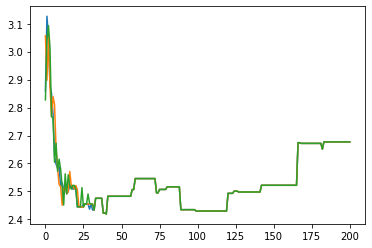

In [241]:
plt.plot(losses[:, 0])
plt.plot(losses[:, 1])
plt.plot(losses[:, 2])
plt.show()